# EDA

Resize Images & Data Augmentation

- Applying various transformations (e.g., rotation, translation, cropping, flipping) to your existing data to create new training examples. It helps improve the generalization of the model and make it more robust, its primary purpose is to increase the diversity of your training data

- noticed imbalanced data from EDA -- > consider metrics like precision, recall, F1-score, ROC-AUC, and precision-recall curves or oversampling

Data Source

- Facebook images: https://www.facebook.com/ClearLakeWaterQuality/photos  

- Cayuga lake: https://www.google.com/maps/d/u/0/viewer?ll=42.72248157357619%2C-76.69514880468749&z=13&mid=1YleiEzCxXTng_6u6zleDOf7TomsSOxTU  

4 Categories for Microcystin Level

- No Advisory: <0.8mg/L, Caution(Tier 1): >=0.8 mg/L, Warning(Tier 2): >=6 mg/L, Danger(Tier3): >=20 mg/L

- Data: https://drive.google.com/drive/u/0/folders/1_tqppLbnBN76zAR9SY-orScsVDhw98X

In [21]:
# For Data Processing
import numpy as np
import pandas as pd
import os
import random
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import seaborn as sns


# For ML Models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
import sklearn.metrics as metrics
from tensorflow.keras import regularizers
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random

In [22]:
#Paths to data directories
Cayuga_lake_dir = './Cayuga_Lake'
Clear_lake_dir = './Clear_Lake'

#Pull in training data
cayuga_data = []
cayuga_data_labels = []

clear_lake_data = []
clear_lake_labels = []

#getting the paths and labels of our cayuga data
for label in os.listdir(Cayuga_lake_dir):
    for image in os.listdir(Cayuga_lake_dir+'/'+label):
        cayuga_data.append(Cayuga_lake_dir+'/'+label+'/'+image)
        cayuga_data_labels.append(label)

#getting the paths and labels of our clear_lake data
for label in os.listdir(Clear_lake_dir):
    for image in os.listdir(Clear_lake_dir+'/'+label):
        clear_lake_data.append(Clear_lake_dir+'/'+label+'/'+image)
        clear_lake_labels.append(label)

cayuga_data, cayuga_data_labels = shuffle(cayuga_data, cayuga_data_labels)
clear_lake_data, clear_lake_labels = shuffle(clear_lake_data, clear_lake_labels)

In [23]:
df_clear = pd.DataFrame({'image_path': clear_lake_data, 'label':clear_lake_labels})
df_clear

image_path  \
0  ./Clear_Lake/[Danger(Tier 3)] x _= 20 mg-L/118...   
1  ./Clear_Lake/[Warning(Tier 2)] 6 mg-L _= x _= ...   
2  ./Clear_Lake/[Danger(Tier 3)] x _= 20 mg-L/118...   
3  ./Clear_Lake/[Caution(Tier 1)] 0.8 mg-L _= x _...   

                                       label  
0              [Danger(Tier 3)] x _= 20 mg-L  
1   [Warning(Tier 2)] 6 mg-L _= x _= 20 mg-L  
2              [Danger(Tier 3)] x _= 20 mg-L  
3  [Caution(Tier 1)] 0.8 mg-L _= x _= 6 mg-L

In [24]:
df_cayuga = pd.DataFrame({'image_path': cayuga_data, 'label':cayuga_data_labels})
df_cayuga

image_path  \
0    ./Cayuga_Lake/[Danger(Tier3)] x_=20 mg-L/L42.png   
1      ./Cayuga_Lake/[No Advisory] x_0.8mg-L/L120.png   
2   ./Cayuga_Lake/[Warning(Tier 2)] 6 mg-L _= x _=...   
3       ./Cayuga_Lake/[No Advisory] x_0.8mg-L/L1u.png   
4   ./Cayuga_Lake/[No Advisory] x_0.8mg-L/5AJ9UNGq...   
..                                                ...   
90      ./Cayuga_Lake/[No Advisory] x_0.8mg-L/l12.png   
91   ./Cayuga_Lake/[Danger(Tier3)] x_=20 mg-L/L4q.png   
92  ./Cayuga_Lake/[Danger(Tier3)] x_=20 mg-L/5AJ9U...   
93      ./Cayuga_Lake/[No Advisory] x_0.8mg-L/L1h.png   
94   ./Cayuga_Lake/[Danger(Tier3)] x_=20 mg-L/L4h.png   

                                       label  
0                 [Danger(Tier3)] x_=20 mg-L  
1                    [No Advisory] x_0.8mg-L  
2   [Warning(Tier 2)] 6 mg-L _= x _= 20 mg-L  
3                    [No Advisory] x_0.8mg-L  
4                    [No Advisory] x_0.8mg-L  
..                                       ...  
90                   [No Advisory] x_0.8mg-L  
91                [Danger(Tier3)] x_=20 mg-L  
92                [Danger(Tier3)] x_=20 mg-L  
93                   [No Advisory] x_0.8mg-L  
94                [Danger(Tier3)] x_=20 mg-L  

[95 rows x 2 columns]

## Distribution of Images

See below for the distribution of images across Cayuga Lake and Clear Lake.

- In the case of Clear Lake, we observe that the majority of images are categorized in the Danger (Tier 3) category, followed by Warning (Tier 2), Caution (Tier 1), and No Advisory. We hypothesize that this is because the data was extracted from a Facebook group, and individuals tend to post images primarily when they want to warn others about the water quality.

- For Cayuga Lake data, we found that most images are classified under Danger (Tier 3), followed by No Advisory, Caution (Tier 1), and then Warning (Tier 2). We hypothesize that this distribution is influenced by the organization's emphasis on distinguishing safe water from dangerous water, which is reflected in the notable concentrations within these two categories.

In [25]:
# append cayuga and clear_lake df
df_cayuga['Lake'] = 'cayuga'
df_clear['Lake'] = 'clear'
df = pd.concat([df_cayuga, df_clear], ignore_index = True)

# make sure label names match
replace_dict = {'[Danger(Tier3)] x_=20 mg-L': '[Danger(Tier 3)] x _= 20 mg-L', '[No Advisory] x_0.8mg-L': '[No Advisory] x _ 0.8mg-L'}
df.loc[df['label'].isin(replace_dict.keys()), 'label'] = df.label.map(replace_dict)

df.label.value_counts()

[Danger(Tier 3)] x _= 20 mg-L                49
[No Advisory] x _ 0.8mg-L                    34
[Caution(Tier 1)] 0.8 mg-L _= x _= 6 mg-L    11
[Warning(Tier 2)] 6 mg-L _= x _= 20 mg-L      5
Name: label, dtype: int64

In [26]:
# Assuming df is your DataFrame and 'label' is the column with class labels
balanced_df = pd.DataFrame()

for label, group in df.groupby('label'):
    if group.shape[0] > 50:
        balanced_group = group.sample(50, replace=False)
    else:
        balanced_group = group.sample(50, replace=True)
    balanced_df = pd.concat([balanced_df, balanced_group])

# Reset index for the final DataFrame
balanced_df.reset_index(drop=True, inplace=True)

print(balanced_df['label'].value_counts())

df = balanced_df

[Caution(Tier 1)] 0.8 mg-L _= x _= 6 mg-L    50
[Danger(Tier 3)] x _= 20 mg-L                50
[No Advisory] x _ 0.8mg-L                    50
[Warning(Tier 2)] 6 mg-L _= x _= 20 mg-L     50
Name: label, dtype: int64


In [27]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


In [28]:
# Define a dictionary with the mappings
label_mapping = {
    '[No Advisory] x _ 0.8mg-L': 0,
    '[Caution(Tier 1)] 0.8 mg-L _= x _= 6 mg-L': 1,
    '[Warning(Tier 2)] 6 mg-L _= x _= 20 mg-L': 2,
    '[Danger(Tier 3)] x _= 20 mg-L': 3
}

# Create the 'encoded_labels' column
train_df['encoded_labels'] = train_df['label'].map(label_mapping)
test_df['encoded_labels'] = test_df['label'].map(label_mapping)

## Visualize the Images

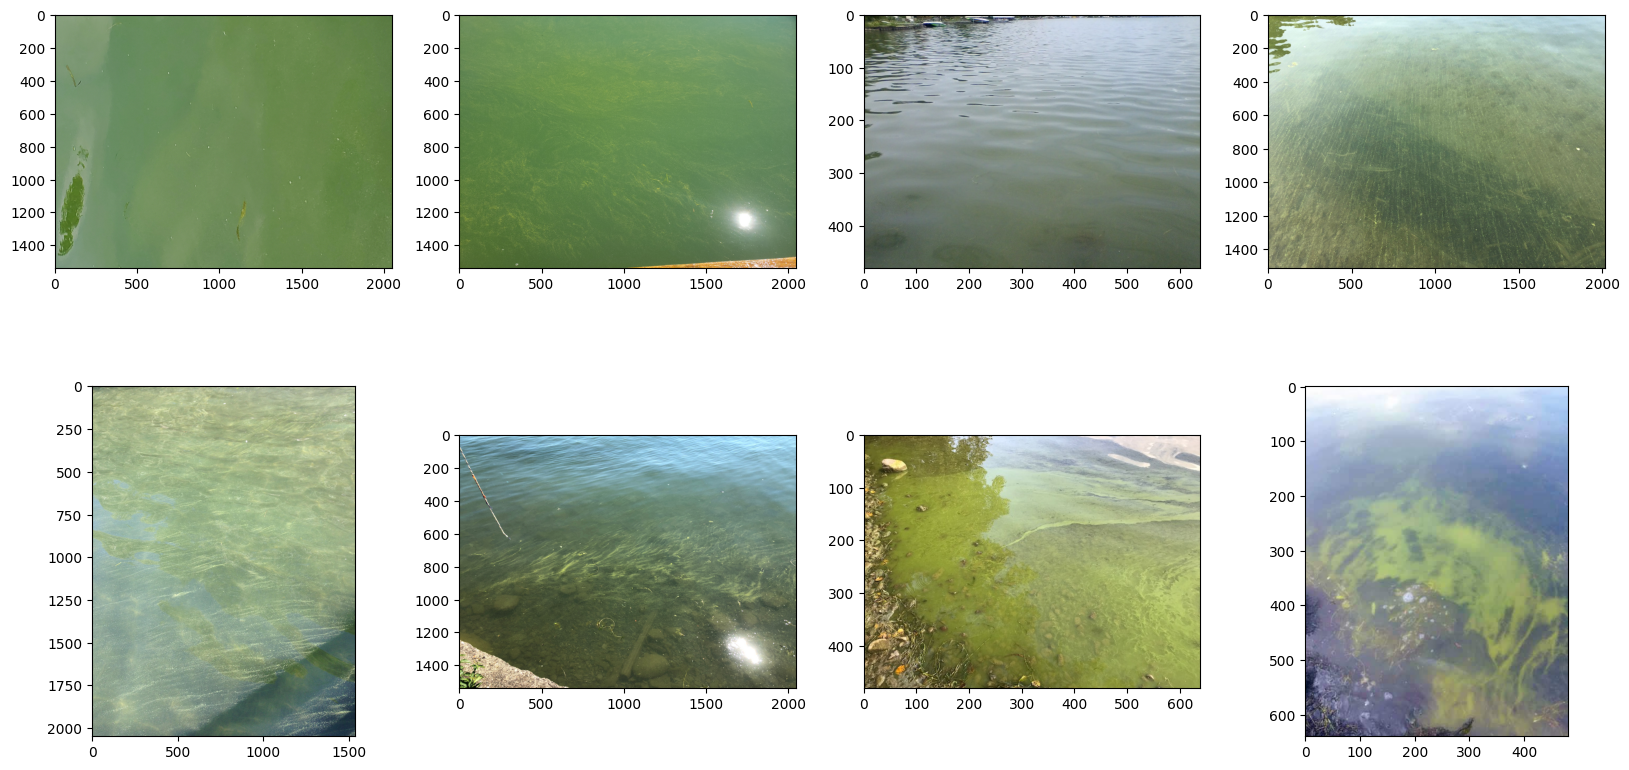

In [29]:
#check first few images of training set
images = []
for idx, img in enumerate(df_cayuga.image_path):
    img = load_img(
    img)
    images.append(img)
    
nrows, ncols = 2,4 #print first 8 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
indx = 0
for i in range(nrows):
    for j in range(ncols):
        axs[i,j].imshow(images[indx])
        indx += 1

IndexError: list index out of range

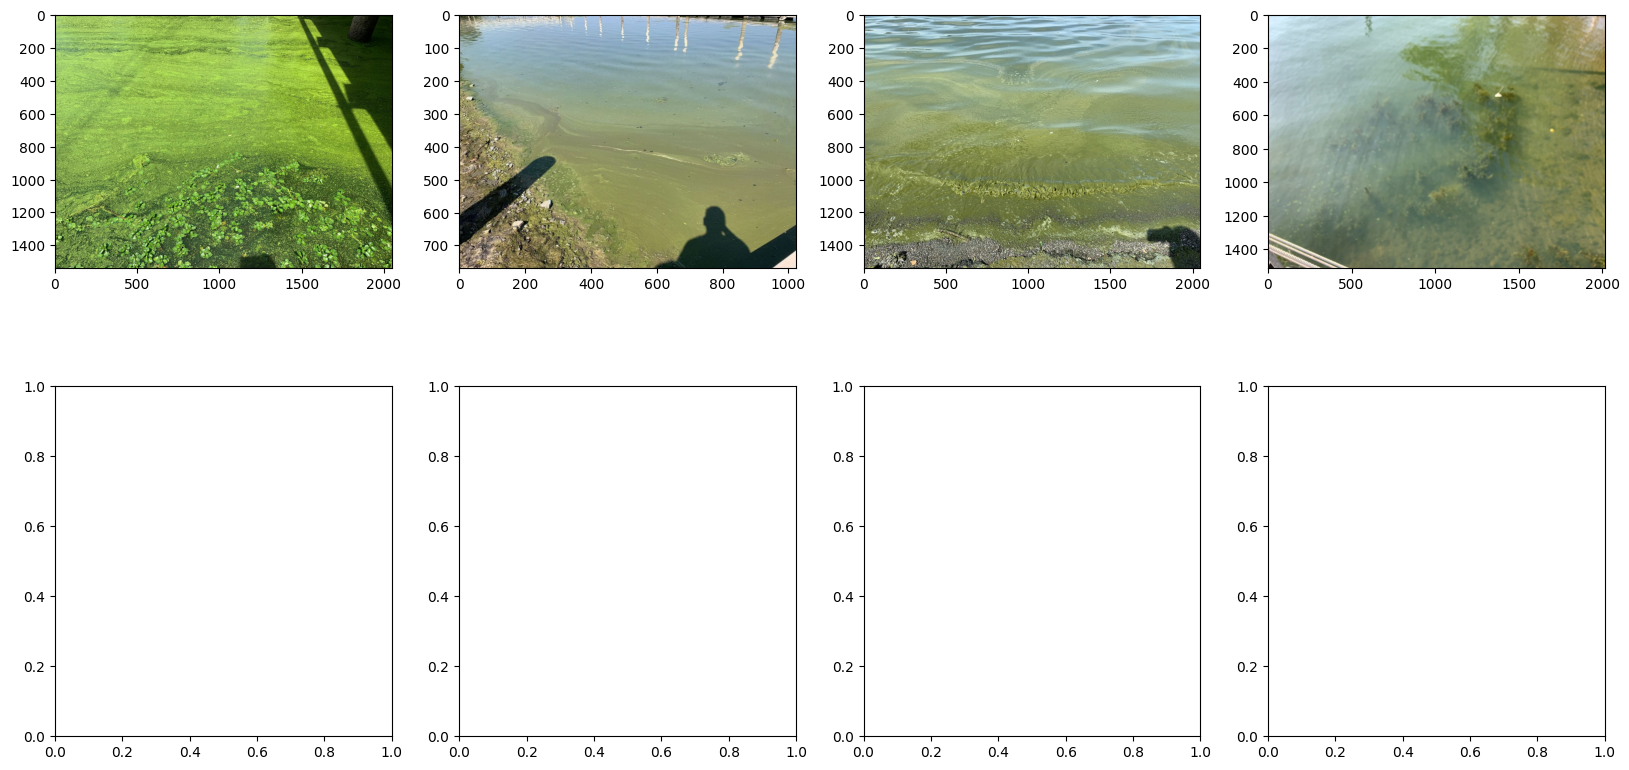

In [31]:
#check first few images of training set
images = []
for idx, img in enumerate(df_clear.image_path):
    img = load_img(
    img)
    images.append(img)
    
nrows, ncols = 2,4 #print first 8 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
indx = 0
for i in range(nrows):
    for j in range(ncols):
        axs[i,j].imshow(images[indx])
        indx += 1

## Size of the Images 

In [32]:
#Changing test set to match format of training data. This is independent to the following preprocessing functions because augmentations are not required
def test_set(data):
    images_mini = []
    for img in (data.image_path):
        img = load_img(img, target_size = (224,224))
        
        img = img_to_array(img)
        
        images_mini.append(img)
    
    X_test = np.stack(images_mini)
    y_test = np.array(data.encoded_labels).flatten()

    X_test = X_test/255

    return X_test, y_test
X_test, y_test = test_set(test_df)

In [33]:
def preprocess1(data):
    images_mini = []
    
    #basically two arrays with images and labels
    for img in (data.image_path):
        img = load_img(img, target_size = (224,224))
        
        img = img_to_array(img)
        
        images_mini.append(img)
    #turns the array into a numpy array with each element in a seperate dimension
    images_mini = np.stack(images_mini)
    y_mini = np.array(data.encoded_labels).flatten()
    return images_mini, y_mini

images_mini, y_mini = preprocess1(train_df)
print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


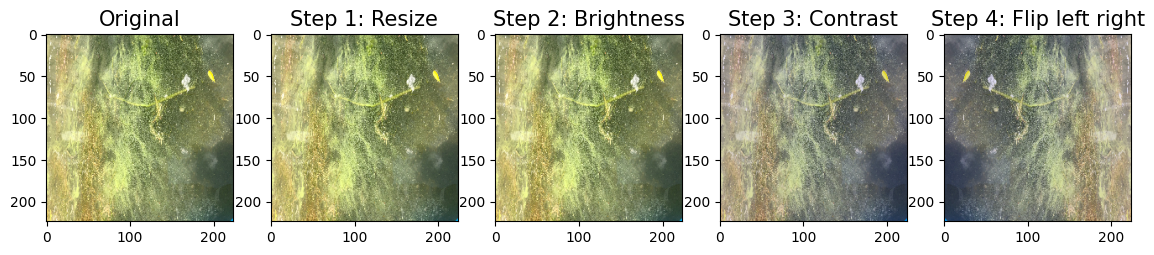

In [34]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(224, 224))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);


# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

# Data Preprocessing

## Data Augmentation

In [35]:
contrast = 3
DELTA = 0.3

def preprocess2(images_mini, y_mini, split= (0.8,0.2)):
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images_mini.shape[0]))
    images_mini, y_mini = images_mini[shuffle], y_mini[shuffle]
    
    #splits for validation
    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val = np.split(images_mini, [splits[0]])
    y_train, y_val = np.split(y_mini, [splits[0]])
    
    #greyscaling
    X_train = X_train/255.0
    X_val = X_val/255.0
    
    #image augmentation
    X_train_augm = tf.image.adjust_brightness(X_train, delta = DELTA)
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor = contrast)
    
    #flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    #concatenate original and augmented
    X_train = tf.concat([X_train, X_train_augm], axis = 0)
    
    #concatenate y_train
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm], axis = 0)
    
    #Shuffle
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype = tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy()
    
    return X_train, y_train, X_val, y_val

In [36]:
X_train, y_train, X_val, y_val = preprocess2(
    images_mini,
    y_mini,
    split=(0.8,0.2)
)

In [37]:
#We have 5104 observations, each having 200x200 pixels, with each pixel having 3 values (which are all the same because they've been greyscaled)
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")

X_train shape (256, 224, 224, 3)
y_train shape (256,)
X_val shape (32, 224, 224, 3)
y_val shape (32,)


Print training data examples:


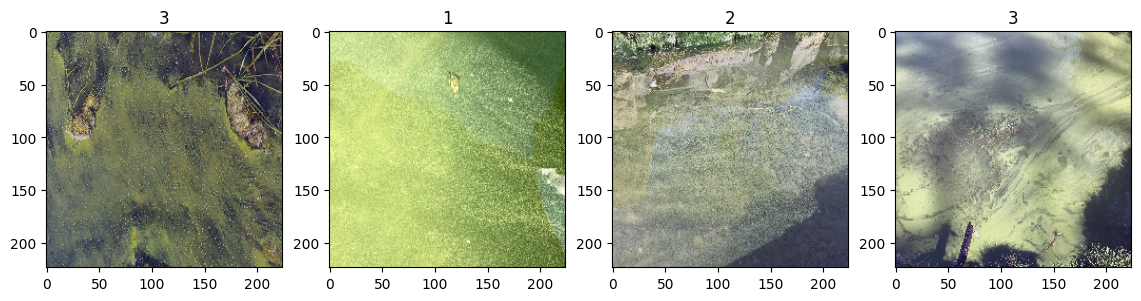

In [38]:
# print taining data
print('Print training data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])

Print validation data examples:


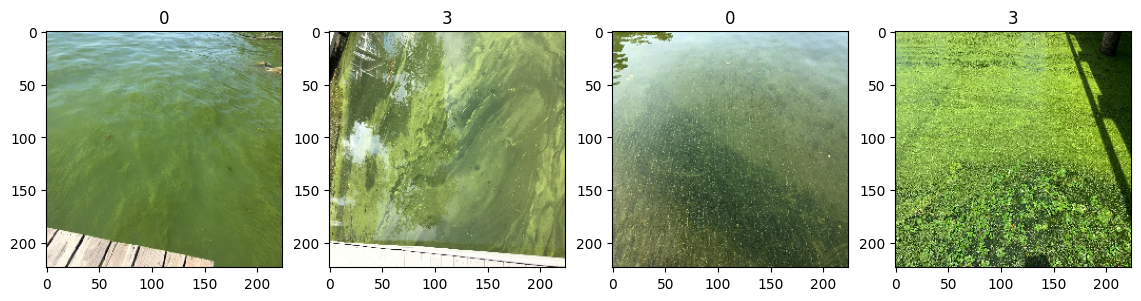

In [39]:
print('Print validation data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_val[i]))
    axs[i].set(title=y_val[i])

Epoch 1/30
8/8 [==============================] - 16s 2s/step - loss: 140.6643 - sparse_categorical_accuracy: 0.2383 - val_loss: 17.7871 - val_sparse_categorical_accuracy: 0.3438
Epoch 2/30
8/8 [==============================] - 13s 2s/step - loss: 6.0088 - sparse_categorical_accuracy: 0.4727 - val_loss: 1.1284 - val_sparse_categorical_accuracy: 0.5625
Epoch 3/30
8/8 [==============================] - 13s 2s/step - loss: 1.3641 - sparse_categorical_accuracy: 0.7578 - val_loss: 1.1762 - val_sparse_categorical_accuracy: 0.6562
Epoch 4/30
8/8 [==============================] - 13s 2s/step - loss: 0.9143 - sparse_categorical_accuracy: 0.7734 - val_loss: 1.0893 - val_sparse_categorical_accuracy: 0.6250
Epoch 5/30
8/8 [==============================] - 13s 2s/step - loss: 0.8632 - sparse_categorical_accuracy: 0.7969 - val_loss: 0.8709 - val_sparse_categorical_accuracy: 0.7188
Epoch 6/30
8/8 [==============================] - 13s 2s/step - loss: 0.5309 - sparse_categorical_accuracy: 0.8242 - 

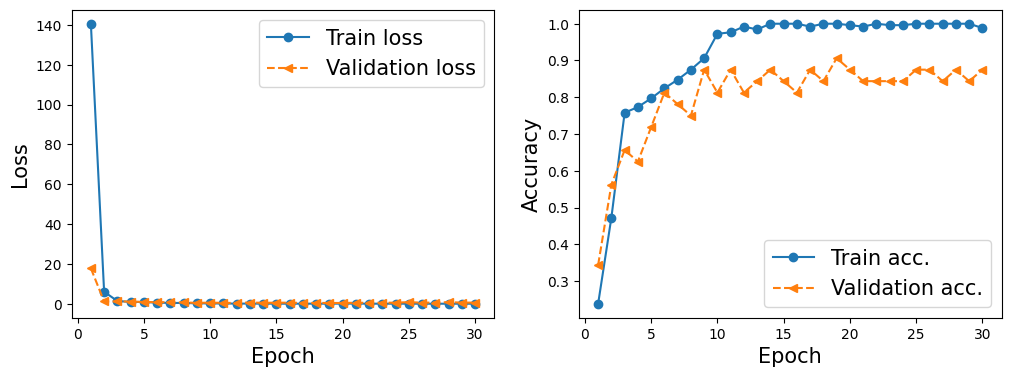

1/1 [==============================] - 0s 192ms/step
[0.796875]
[0.71875]
[0.7272727272727273]
[1.0]
[1.0]
[0.8888888888888888]


In [40]:
kernel_sizes = [(5,5)]
strides_list = [(1,1)]
pool_sizes = [(2,2)]
learning_rates = [.001]
training_accuracies = []
validation_accuracies = []
recall_0 = []
recall_1 = []
recall_2 = []
recall_3 = []

for i in range(1):
    tf.keras.backend.clear_session()
    
    model = tf.keras.Sequential()

    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_sizes[i],
        strides=strides_list[i],
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))

    # add a max pooling layer
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=pool_sizes[i],
        name='pool_1'))

    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=1028,
        name='fc_1', 
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add the last fully connected layer
    # set units=4 to get a four output units (remember it's a multinomial classification problem)
    model.add(tf.keras.layers.Dense(
        units=4,
        name='fc_2',
        activation='softmax'))

    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 224, 224, 3))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rates[i]),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']) 
    
    tf.random.set_seed(1234)
    np.random.seed(1234)
    history = model.fit(X_train, y_train,
                        epochs=30, 
                        validation_data=(X_val, y_val)
    )
    #plotting loss and accuracy curves
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['sparse_categorical_accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_sparse_categorical_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    # plt.savefig(f'Hyperparams/multi_1_layer_history_plot({i}).png', bbox_inches='tight')
    plt.show()
    
    #Saving training and validation accuracy
    training_accuracies.append(pd.DataFrame(hist)['sparse_categorical_accuracy'][4])
    validation_accuracies.append(pd.DataFrame(hist)['val_sparse_categorical_accuracy'][4])

    
    #Saving validation recall
    # get the predicted probabilities for the validation set
    y_pred = model.predict(X_val)
    y_val_pred = np.argmax(y_pred, axis=1)
    
    # compute the recall score for each class
    recall_scores = metrics.recall_score(y_val, y_val_pred, average=None)
    recall_0.append(recall_scores[0])
    recall_1.append(recall_scores[1])
    recall_2.append(recall_scores[2])
    recall_3.append(recall_scores[3])

print(training_accuracies)
print(validation_accuracies)
print(recall_0)
print(recall_1)
print(recall_2)
print(recall_3)

In [41]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
confusion = confusion_matrix(y_val, y_val_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)


Confusion Matrix:
[[8 0 0 3]
 [0 6 0 0]
 [0 0 6 0]
 [0 1 0 8]]


In [42]:
# Assuming you have a trained model called 'model'
y_test_pred = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred, axis=1)


2/2 [==============================] - 0s 62ms/step


In [43]:
confusion = confusion_matrix(y_test, y_test_pred)

print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 2  1  0  7]]


Epoch 1/30
8/8 [==============================] - 7s 770ms/step - loss: 9.7555 - sparse_categorical_accuracy: 0.2109 - val_loss: 1.3894 - val_sparse_categorical_accuracy: 0.1875
Epoch 2/30
8/8 [==============================] - 6s 725ms/step - loss: 1.2506 - sparse_categorical_accuracy: 0.4180 - val_loss: 1.3752 - val_sparse_categorical_accuracy: 0.4062
Epoch 3/30
8/8 [==============================] - 6s 753ms/step - loss: 1.1840 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.3841 - val_sparse_categorical_accuracy: 0.1875
Epoch 4/30
8/8 [==============================] - 6s 795ms/step - loss: 1.0576 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.4041 - val_sparse_categorical_accuracy: 0.1875
Epoch 5/30
8/8 [==============================] - 6s 807ms/step - loss: 0.9263 - sparse_categorical_accuracy: 0.6484 - val_loss: 1.3591 - val_sparse_categorical_accuracy: 0.3438
Epoch 6/30
8/8 [==============================] - 7s 824ms/step - loss: 0.9120 - sparse_categorical_accuracy: 

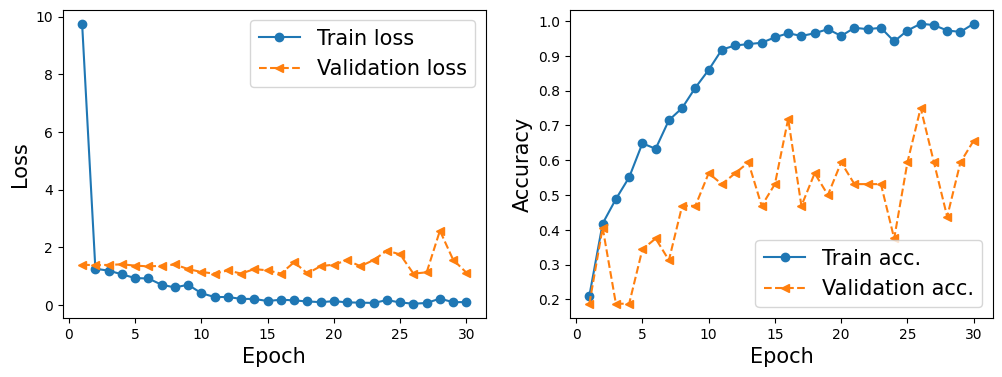

1/1 [==============================] - 0s 133ms/step
[0.6484375]
[0.34375]
[0.8181818181818182]
[0.8333333333333334]
[0.6666666666666666]
[0.3333333333333333]


In [24]:
kernel_sizes = [(5,5)]
strides_list = [(1,1)]
pool_sizes = [(2,2)]
learning_rates = [.001]
training_accuracies = []
validation_accuracies = []
recall_0 = []
recall_1 = []
recall_2 = []
recall_3 = []

for i in range(1):
    tf.keras.backend.clear_session()
    
    model = tf.keras.Sequential()

    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_sizes[i],
        strides=strides_list[i],
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))

    # add a max pooling layer with pool size
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=pool_sizes[i],
        name='pool_1'))
    
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_sizes[i],
        strides=strides_list[i],
        padding='same',
        data_format='channels_last',
        name='conv_2',
        activation='relu'))

    # add a max pooling layer with pool size
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=pool_sizes[i],
        name='pool_2'))
    
    
    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=1024,
        name='fc_1', 
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add the last fully connected layer
    model.add(tf.keras.layers.Dense(
        units=4,
        name='fc_2',
        activation='softmax'))

    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 224, 224, 3))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rates[i]),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']) 
    
    tf.random.set_seed(1234)
    np.random.seed(1234)
    history = model.fit(X_train, y_train,
                        epochs=30, 
                        validation_data=(X_val, y_val)
    )
    #plotting
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['sparse_categorical_accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_sparse_categorical_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    # plt.savefig(f'Hyperparams/multi_2_layer_history_plot({i}).png', bbox_inches='tight')
    plt.show()
    
    #Saving training and validation accuracy
    training_accuracies.append(pd.DataFrame(hist)['sparse_categorical_accuracy'][4])
    validation_accuracies.append(pd.DataFrame(hist)['val_sparse_categorical_accuracy'][4])

    
    #Saving validation recall
    # get the predicted probabilities for the validation set
    y_pred = model.predict(X_val)
    y_val_pred = np.argmax(y_pred, axis=1)
    
    # compute the recall score for each class
    recall_scores = metrics.recall_score(y_val, y_val_pred, average=None)
    recall_0.append(recall_scores[0])
    recall_1.append(recall_scores[1])
    recall_2.append(recall_scores[2])
    recall_3.append(recall_scores[3])

print(training_accuracies)
print(validation_accuracies)
print(recall_0)
print(recall_1)
print(recall_2)
print(recall_3)

Epoch 1/10
8/8 [==============================] - 6s 644ms/step - loss: 2.2218 - sparse_categorical_accuracy: 0.3047 - val_loss: 1.3774 - val_sparse_categorical_accuracy: 0.3125
Epoch 2/10
8/8 [==============================] - 5s 637ms/step - loss: 1.3444 - sparse_categorical_accuracy: 0.3477 - val_loss: 1.3935 - val_sparse_categorical_accuracy: 0.1875
Epoch 3/10
8/8 [==============================] - 5s 623ms/step - loss: 1.2576 - sparse_categorical_accuracy: 0.4219 - val_loss: 1.3625 - val_sparse_categorical_accuracy: 0.2812
Epoch 4/10
8/8 [==============================] - 5s 654ms/step - loss: 1.1475 - sparse_categorical_accuracy: 0.4766 - val_loss: 1.3098 - val_sparse_categorical_accuracy: 0.3438
Epoch 5/10
8/8 [==============================] - 5s 630ms/step - loss: 1.0304 - sparse_categorical_accuracy: 0.5625 - val_loss: 1.3189 - val_sparse_categorical_accuracy: 0.2812
Epoch 6/10
8/8 [==============================] - 5s 585ms/step - loss: 0.9480 - sparse_categorical_accuracy: 

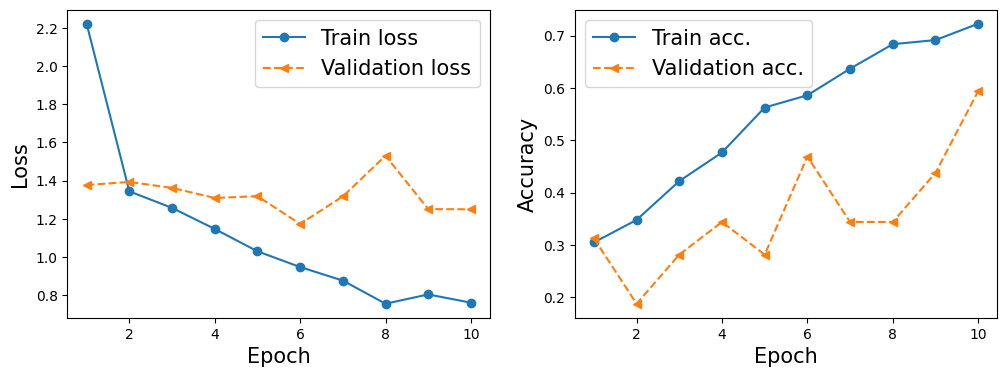

1/1 [==============================] - 0s 124ms/step
[0.5625]
[0.28125]
[0.6363636363636364]
[0.6666666666666666]
[0.3333333333333333]
[0.6666666666666666]


In [22]:
kernel_sizes = [(5,5)]
strides_list = [(1,1)]
pool_sizes = [(2,2)]
learning_rates = [.001]
training_accuracies = []
validation_accuracies = []
recall_0 = []
recall_1 = []
recall_2 = []
recall_3 = []

for i in range(1):
    tf.keras.backend.clear_session()
    
    model = tf.keras.Sequential()

    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_sizes[i],
        strides=strides_list[i],
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))

    # add a max pooling layer with pool size 
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=pool_sizes[i],
        name='pool_1'))
    
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_sizes[i],
        strides=strides_list[i],
        padding='same',
        data_format='channels_last',
        name='conv_2',
        activation='relu'))

    # add a max pooling layer with pool size 
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=pool_sizes[i],
        name='pool_2'))

    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_sizes[i],
        strides=strides_list[i],
        padding='same',
        data_format='channels_last',
        name='conv_3',
        activation='relu'))

    # add a max pooling layer with pool size 
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=pool_sizes[i],
        name='pool_3'))
    
    
    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=1024,
        name='fc_1', 
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add the last fully connected layer
    model.add(tf.keras.layers.Dense(
        units=4,
        name='fc_2',
        activation='softmax'))

    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 224, 224, 3))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rates[i]),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']) 
    
    tf.random.set_seed(1234)
    np.random.seed(1234)
    history = model.fit(X_train, y_train,
                        epochs=10, 
                        validation_data=(X_val, y_val)
    )
    #plotting
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['sparse_categorical_accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_sparse_categorical_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    # plt.savefig(f'Hyperparams/multi_3_layer_history_plot({i}).png', bbox_inches='tight')
    plt.show()
    
    #Saving training and validation accuracy
    training_accuracies.append(pd.DataFrame(hist)['sparse_categorical_accuracy'][4])
    validation_accuracies.append(pd.DataFrame(hist)['val_sparse_categorical_accuracy'][4])

    
    #Saving validation recall
    # get the predicted probabilities for the validation set
    y_pred = model.predict(X_val)
    y_val_pred = np.argmax(y_pred, axis=1)
    
    # compute the recall score for each class
    recall_scores = metrics.recall_score(y_val, y_val_pred, average=None)
    recall_0.append(recall_scores[0])
    recall_1.append(recall_scores[1])
    recall_2.append(recall_scores[2])
    recall_3.append(recall_scores[3])

print(training_accuracies)
print(validation_accuracies)
print(recall_0)
print(recall_1)
print(recall_2)
print(recall_3)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5a2c0ad4-28e2-4ad1-b924-b1f4dd83d778' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>